In [ ]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM, LlamaForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

from datasets import load_dataset

import functools
import gc
from collections import defaultdict
from typing import List

import torch
import torch.nn as nn
import tqdm
# from tinychat.models import LlavaLlamaForCausalLM
from transformers.models.bloom.modeling_bloom import BloomForCausalLM
from transformers.models.llama.modeling_llama import LlamaForCausalLM
from transformers.models.opt.modeling_opt import OPTForCausalLM


In [ ]:
def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        # layers = [model.model.layers, model.model.vision_tower.vision_tower.vision_model.encoder.layers]
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    else:
        raise NotImplementedError(type(model))
    return layers

def get_calib_dataset(data="pileval", tokenizer=None, n_samples=512, block_size=512):
    if data == "pileval":
        # dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
        dataset = load_dataset("NeelNanda/pile-10k", split="train")        
    else:
        raise NotImplementedError
    dataset = dataset.shuffle(seed=42)
    samples = []
    n_run = 0
    for data in dataset:
        line = data["text"]
        line = line.strip()
        line_encoded = tokenizer.encode(line)
        if len(line_encoded) > 512:
            continue
        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        samples.append(sample)
        n_run += 1
        if n_run == n_samples:
            break
    # now concatenate all samples and split according to block size
    cat_samples = torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")
    return [
        cat_samples[:, i * block_size : (i + 1) * block_size] for i in range(n_split)
    ]
    
def move_embed(model, device):
    if isinstance(model, LlamaForCausalLM):
        model.model.embed_tokens = model.model.embed_tokens.to(device)
        ## add the following line to move rotary_emb to GPU as well
        model.model.rotary_emb = model.model.rotary_emb.to(device)
    # elif isinstance(model, LlavaLlamaForCausalLM):
    #     model.model.embed_tokens = model.model.embed_tokens.to(device)
    #     model.model.vision_tower.vision_tower.vision_model.embeddings.to(device)
    elif isinstance(model, OPTForCausalLM):
        model.model.decoder.embed_tokens = model.model.decoder.embed_tokens.to(device)
        model.model.decoder.embed_positions = model.model.decoder.embed_positions.to(device)
    elif isinstance(model, BloomForCausalLM):
        model.transformer.word_embeddings = model.transformer.word_embeddings.to(device)
        model.transformer.word_embeddings_layernorm = model.transformer.word_embeddings_layernorm.to(device)
    elif "mpt" in str(model.__class__).lower():
        model.transformer.wte = model.transformer.wte.to(device)
        model.transformer.emb_drop = model.transformer.emb_drop.to(device)
    elif "falcon" in str(model.__class__).lower():
        model.transformer.word_embeddings = model.transformer.word_embeddings.to(device)
    elif "bigcode" in str(model.__class__).lower():
        model.transformer.wte = model.transformer.wte.to(device)
        model.transformer.wpe = model.transformer.wpe.to(device)
        model.transformer.drop = model.transformer.drop.to(device)
    elif "neox" in str(model.__class__).lower():
        model.gpt_neox.embed_in = model.gpt_neox.embed_in.to(device)
        model.gpt_neox.emb_dropout = model.gpt_neox.emb_dropout.to(device)
        model.embed_out = model.embed_out.to(device)
    else:
        raise NotImplementedError(type(model))

In [ ]:
@torch.no_grad()
def save_input_feat_per_sample(
    model,
    enc,
    samples
):
    # from ..utils.calib_data import get_calib_dataset
    # from ..utils.module import append_str_prefix, get_op_name
    
    input_feats = []

    if "bigcode" in str(model.__class__).lower():
        # otherwise attention_mask will always be on cpu.
        model.transformer.bias = model.transformer.bias.to("cuda")

    layers = get_blocks(model)

    # samples = get_calib_dataset(data=calib_data, tokenizer=enc, n_samples=n_samples, block_size=seqlen)
    # samples = torch.cat(samples, dim=0)

    inps = []
    layer_kwargs = {}

    layers[0] = layers[0].cuda()
    move_embed(model, "cuda")

    # get input and kwargs to layer 0
    # with_kwargs is only supported in PyTorch 2.0
    # use this Catcher hack for now
    class Catcher(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module

        def forward(self, inp, **kwargs):
            inps.append(inp)
            layer_kwargs.update(kwargs)
            raise ValueError  # early exit to break later inference

    # patch layer 0 to catch input and kwargs
    layers[0] = Catcher(layers[0])
    try:
        model(samples.to(next(model.parameters()).device))
    except ValueError:  # work with early exit
        pass
    del samples
    layers[0] = layers[0].module  # restore
    inps = inps[0]

    layers[0] = layers[0].cpu()
    move_embed(model, "cpu")

    gc.collect()
    torch.cuda.empty_cache()

    # solve layer by layer
    for i in tqdm.tqdm(range(len(layers)), desc="Running AWQ..."):
    # for i in tqdm.tqdm(range(3), desc="Running AWQ..."):
        layer = layers[i]
        layer = layer.cuda()
        named_linears = get_named_linears(layer)

        # firstly, get input features of all linear layers
        def cache_input_hook(m, x, y, name, feat_dict):
            x = x[0]
            x = x.detach().cpu()
            feat_dict[name].append(x)

        input_feat = defaultdict(list)
        handles = []
        for name in named_linears:
            handles.append(
                named_linears[name].register_forward_hook(
                    functools.partial(cache_input_hook, name=name, feat_dict=input_feat)
                )
            )
        inps = inps.to(next(layer.parameters()).device)  # in case multi-gpu
        # get output as next layer's input
        inps = layer(inps, **layer_kwargs)[0]
        for h in handles:
            h.remove()
        # now solve for scaling and clipping
        input_feat = {k: torch.cat(v, dim=0) for k, v in input_feat.items()}            
        input_feats.append(input_feat)
                
        # Clear GPU memory
        layer = layer.cpu()
        # Haotian: check activation replacement
        del input_feat
        gc.collect()
        torch.cuda.empty_cache()
        
    return input_feats

In [ ]:
## 메모리 부족해서 안 돌아감

# @torch.no_grad()
# def save_input_hess(
#     model,
#     enc,
#     n_samples=512,
#     seqlen=512,
#     calib_data="pileval"
#     # samples
# ):
#     # from ..utils.calib_data import get_calib_dataset
#     # from ..utils.module import append_str_prefix, get_op_name
    
#     input_feat_hess = []

#     if "bigcode" in str(model.__class__).lower():
#         # otherwise attention_mask will always be on cpu.
#         model.transformer.bias = model.transformer.bias.to("cuda")

#     layers = get_blocks(model)

#     samples = get_calib_dataset(data=calib_data, tokenizer=enc, n_samples=n_samples, block_size=seqlen)
#     samples = torch.cat(samples, dim=0)

#     inps = []
#     layer_kwargs = {}

#     layers[0] = layers[0].cuda()
#     move_embed(model, "cuda")

#     # get input and kwargs to layer 0
#     # with_kwargs is only supported in PyTorch 2.0
#     # use this Catcher hack for now
#     class Catcher(nn.Module):
#         def __init__(self, module):
#             super().__init__()
#             self.module = module

#         def forward(self, inp, **kwargs):
#             inps.append(inp)
#             layer_kwargs.update(kwargs)
#             raise ValueError  # early exit to break later inference

#     # patch layer 0 to catch input and kwargs
#     layers[0] = Catcher(layers[0])
#     try:
#         model(samples.to(next(model.parameters()).device))
#     except ValueError:  # work with early exit
#         pass
#     del samples
#     layers[0] = layers[0].module  # restore
#     inps = inps[0]

#     layers[0] = layers[0].cpu()
#     move_embed(model, "cpu")

#     gc.collect()
#     torch.cuda.empty_cache()

#     # solve layer by layer
#     for i in tqdm.tqdm(range(len(layers)), desc="Running AWQ..."):
#     # for i in tqdm.tqdm(range(3), desc="Running AWQ..."):
#         layer = layers[i]
#         layer = layer.cuda()
#         named_linears = get_named_linears(layer)

#         # firstly, get input features of all linear layers
#         def cache_input_hook(m, x, y, name, feat_dict):
#             x = x[0]
#             x = x.detach().cpu()
#             feat_dict[name].append(x)

#         input_feat = defaultdict(list)
#         handles = []
#         for name in named_linears:
#             handles.append(
#                 named_linears[name].register_forward_hook(
#                     functools.partial(cache_input_hook, name=name, feat_dict=input_feat)
#                 )
#             )
#         inps = inps.to(next(layer.parameters()).device)  # in case multi-gpu
#         # get output as next layer's input
#         inps = layer(inps, **layer_kwargs)[0].detach().cpu() 
#         for h in handles:
#             h.remove()
#         # now solve for scaling and clipping
#         # input_feat = {k: torch.cat(v, dim=0) for k, v in input_feat.items()}
        
#         ##
#         for k, v in input_feat.items():
#             v = torch.cat(v, dim=0).cuda()
#             v = v.view(-1, v.size(-1))
#             H = torch.mm(v.T, v).cpu()
#             input_feat = {k: H}
            
#         input_feat_hess.append(input_feat)
                
#         # Clear GPU memory
#         layer = layer.cpu()
#         # Haotian: check activation replacement
#         del input_feat
#         gc.collect()
#         torch.cuda.empty_cache()
        
#     return input_feat_hess

# Save in feat per samples

In [ ]:
model_list = [
    # 'meta-llama/Llama-2-7b-hf',
    # 'meta-llama/Llama-2-13b-hf',
    # 'meta-llama/Meta-Llama-3-8B',
    # 'lmsys/vicuna-7b-v1.5',
    # 'lmsys/vicuna-13b-v1.5',
    'facebook/opt-6.7b',
]

n_samples=128
seqlen=512
calib_data="pileval"

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)

    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only = True)

    for param in model.parameters():
        param.requires_grad = False

    samples = get_calib_dataset(data=calib_data, tokenizer=tokenizer, n_samples=n_samples, block_size=seqlen)
    samples = torch.cat(samples, dim=0)

    # for i in range(samples.size(0)):
    #     result = save_input_feat_per_sample(model, tokenizer, samples = samples[i].unsqueeze(0))
    #     save_path = f'./input_feat_per_sample/{model_name}/sample{i}.pt'
    
    batch_size = 12
    num_samples = samples.size(0)
    save_path = f'./input_feat_per_sample/{model_name}' 
    os.makedirs(save_path, exist_ok=True)
    
    for i in range(0, num_samples, batch_size):
        print(f'batch {i}')
        batch_samples = samples[i : min(i + batch_size, num_samples)]
        result = save_input_feat_per_sample(model, tokenizer, samples=batch_samples)
        
        torch.save(result, save_path + f'/batch_{i}.pt')

# Cal Hess

In [ ]:
model_list = [
    # 'meta-llama/Llama-2-7b-hf',
    # 'meta-llama/Llama-2-13b-hf',
    # 'meta-llama/Meta-Llama-3-8B',
    # 'lmsys/vicuna-7b-v1.5',
    'lmsys/vicuna-13b-v1.5',
    'facebook/opt-6.7b',
]

n_samples=128
seqlen=512
calib_data="pileval"
batch_size = 12

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)

    model_path = f"./hf_model/{model_name}"
    save_path = f'./input_feat_per_sample/{model_name}' 
    
    num_layer =  len(torch.load(save_path + f'/batch_0.pt'))
    
    hessian_all_layer = []
    
    in_feats = []
    for i in range(0, 68, batch_size):            
        in_feat = torch.load(save_path + f'/batch_{i}.pt')
        in_feats.append(in_feat)    
    
    for layer_id in tqdm.tqdm(range(num_layer), desc='Calculating Hess per layer..'):
        
        in_feats_one_layer = defaultdict(list)
        
        for i in range(len(in_feats)):
            layer = in_feats[i][layer_id]
            for name in layer:
                in_feats_one_layer[name].append(layer[name])   
            
        # for i in range(0, 68, batch_size):            
        #     in_feat = torch.load(save_path + f'/batch_{i}.pt')
        #     layer = in_feat[layer_id]
            
        #     for name in layer:
        #         in_feats_one_layer[name].append(layer[name])                
        
        for k, v in in_feats_one_layer.items():
            v = torch.cat(v, dim=0).cuda()
            v = v.view(-1, v.size(-1))
            H = torch.mm(v.T, v).cpu()
            print(k, H.shape)
            in_feats_one_layer[k] = H
        
        hessian_all_layer.append(in_feats_one_layer)

    save_path = f'./hessian/{model_name}'
    os.makedirs(save_path, exist_ok=True)
    torch.save(hessian_all_layer, save_path + f'/{calib_data}_n_samples{n_samples}_seqlen{seqlen}.pt')
        


# In channel qaulity level

In [ ]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama/Llama-2-7b-hf',
    # 'meta-llama/Llama-2-13b-hf',
    # 'lmsys/vicuna-7b-v1.5',
    # 'lmsys/vicuna-13b-v1.5',
    # 'facebook/opt-6.7b',
]

n_samples=128
seqlen=512
calib_data="pileval"
batch_size = 12

# top = np.array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5])
# qlevel = [7, 6, 5, 4, 3, 2, 1]

top = np.array([0.0827,0.1453,0.4004,1.1037,3.0424,8.3863,23.1170,63.7223])
qlevel = [7, 6, 5, 4, 3, 2, 1]

# top = np.array([0.0498,0.0329,0.0546,0.0907,0.1505,0.2499,0.4149,0.6888,1.1436,1.8987,3.1524,5.2339,8.6897,14.4273,23.9533,39.7690])
# qlevel = [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)

    model_path = f"./hf_model/{model_name}"

    save_path = f'./hessian/{model_name}'
    os.makedirs(save_path, exist_ok=True)
    hess  = torch.load(save_path + f'/{calib_data}_n_samples{n_samples}_seqlen{seqlen}.pt')
    
    input_ch_qlevel = []
    for i in range(len(hess)):
        
        ql_one_layer = defaultdict(list)
        
        for n, h in hess[i].items():
            print(i, n, h.shape)
            
            in_norm = torch.diag(h)
            topk = (top * len(in_norm)/100).astype(int)
            
            quality = torch.zeros_like(in_norm, dtype=torch.int32)
            _, topk_indices = torch.topk(in_norm, k=topk.sum())
            start = 0
            
            for count, value in zip(topk , qlevel):
                indices = topk_indices[start:start + count]
                quality[indices] = value
                start += count            
            
            ql_one_layer[n] = quality
        
        input_ch_qlevel.append(ql_one_layer)
    
    torch.save(input_ch_qlevel, save_path + f'/{calib_data}_n_samples{n_samples}_seqlen{seqlen}_top{len(top)}_qlevel{len(qlevel)}.pt')
    

In [ ]:
for i in range(len(input_ch_qlevel)):
    for n, h in input_ch_qlevel[i].items():
        print(i, n, h.max())

# In channel qaulity level Quip Hess

In [ ]:
def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

device = 'cpu'

In [ ]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama/Llama-2-7b-hf',
    'meta-llama/Llama-2-13b-hf',
    # 'lmsys/vicuna-7b-v1.5',
    # 'lmsys/vicuna-13b-v1.5',
    # 'facebook/opt-6.7b',
]

quip_hess_path = [
    '/home/jgryu/Weight_compression/Wparam_dataset/quip_hess/llama3_8b_6144',
    '/home/jgryu/Weight_compression/Wparam_dataset/quip_hess/Hessians-Llama-2-7b-6144',
    '/home/jgryu/Weight_compression/Wparam_dataset/quip_hess/Hessians-Llama-2-13b-6144'
]

n_samples=6144

top = np.array([0.1, 1.0, 10.0])
qlevel = [3, 2, 1]

for model_name, quip_hess in zip(model_list, quip_hess_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)

    model_path = f"./hf_model/{model_name}"
    
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    save_path = f'./hessian/{model_name}'
    os.makedirs(save_path, exist_ok=True)
    
    input_ch_qlevel = []
    for i in tqdm.tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        ql_one_layer = defaultdict(list)
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        
        for n, m in named_linears.items():            
            if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n:
                H_flat = hess_dict['qkv']
            elif 'o_proj' in n:
                H_flat = hess_dict['o']
            elif 'up_proj' in n or 'gate_proj' in n:
                H_flat = hess_dict['up']
            elif 'down_proj' in n:
                H_flat = hess_dict['down']
            else:
                raise NotImplementedError(n)
            
            H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
            mu = H_flat['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])
            
            in_norm = torch.diag(H)
            topk = (top * len(in_norm)/100).astype(int)
            
            quality = torch.zeros_like(in_norm, dtype=torch.int32)
            _, topk_indices = torch.topk(in_norm, k=topk.sum())
            start = 0
            
            for count, value in zip(topk , qlevel):
                indices = topk_indices[start:start + count]
                quality[indices] = value
                start += count            
            
            ql_one_layer[n] = quality.to('cpu')
        
        input_ch_qlevel.append(ql_one_layer)
    
    torch.save(input_ch_qlevel, save_path + f'/quip_hess_n{n_samples}_top{len(top)}_qlevel{len(qlevel)}.pt')
    

# 전체 레이어에서 Q level 뽑기

In [ ]:
model_list = [
    # 'meta-llama/Meta-Llama-3-8B',
    'meta-llama/Llama-2-7b-hf',
    # 'meta-llama/Llama-2-13b-hf',
    # 'lmsys/vicuna-7b-v1.5',
    # 'lmsys/vicuna-13b-v1.5',
    # 'facebook/opt-6.7b',
]

quip_hess_path = [
    # '/home/jgryu/Weight_compression/Wparam_dataset/quip_hess/llama3_8b_6144',
    './quip_hess/Hessians-Llama-2-7b-6144',
    # '/home/jgryu/Weight_compression/Wparam_dataset/quip_hess/Hessians-Llama-2-13b-6144'
]

n_samples=6144

top = np.array([0.1, 1.0, 10.0])
qlevel_values = [3, 2, 1]

for model_name, quip_hess in zip(model_list, quip_hess_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)

    model_path = f"./hf_model/{model_name}"
    
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    save_path = f'./hessian/{model_name}'
    os.makedirs(save_path, exist_ok=True)
    
    hdiag = []
    ori_shape = []
    name = []
    for i in tqdm.tqdm(range(len(layers))):
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():            
            if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n:
                H_flat = hess_dict['qkv']
            elif 'o_proj' in n:
                H_flat = hess_dict['o']
            elif 'up_proj' in n or 'gate_proj' in n:
                H_flat = hess_dict['up']
            elif 'down_proj' in n:
                H_flat = hess_dict['down']
            else:
                raise NotImplementedError(n)

            H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
            mu = H_flat['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])
            
            W = m.weight.data
            diagH = torch.diag(H)
            diagW2 = torch.diag(W.T @ W)
            diagH = torch.clamp(diagH, min=1e-8)
            diagW2 = torch.clamp(diagW2, min=1e-8)
            ## v2
            scaleWH = (diagH / diagW2)
            ## v1
            # scaleWH = diagH
            ## v3
            # scaleWH = diagH.sqrt() / (W ** 2).sum().sqrt()

            hdiag.append(scaleWH)
            ori_shape.append(scaleWH.shape)
            name.append(f'{i}_{n}')
            
    split_sizes = [shape[0] for shape in ori_shape]
    hdiag_cat = torch.cat(hdiag)
    
    topk = (top * len(hdiag_cat)/100).astype(int)
    quality = torch.zeros_like(hdiag_cat, dtype=torch.int32)
    _, topk_indices = torch.topk(hdiag_cat, k=topk.sum())

    start = 0
    for count, value in zip(topk , qlevel_values):
        indices = topk_indices[start:start + count]
        quality[indices] = value
        start += count

    quality = torch.split(quality, split_sizes)
    quality = [tensor.view(shape) for tensor, shape in zip(quality, ori_shape)]

    qlevel_dict = {}
    ii = 0
    for i in tqdm.tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            # v3
            if 'o_proj' in n: 
                quality[ii][quality[ii] == 0] = 1
            qlevel_dict[name[ii]] = quality[ii]

            ii += 1

    input_ch_qlevel = []
    for i in tqdm.tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        ql_one_layer = defaultdict(list)

        for n, m in named_linears.items():           
            ql_one_layer[n] = qlevel_dict[f'{i}_{n}'].cpu()

        input_ch_qlevel.append(ql_one_layer)
    
    # torch.save(input_ch_qlevel, save_path + f'/quip_hess_n{n_samples}_all_layers_v3_top{top}_qlevel{qlevel_values}.pt')

model_name:  meta-llama--Llama-2-7b-hf


100%|██████████| 32/32 [00:00<00:00, 30594.42it/s]


In [ ]:
# ## V1

# model_list = [
#     # 'meta-llama/Meta-Llama-3-8B',
#     'meta-llama/Llama-2-7b-hf',
#     # 'meta-llama/Llama-2-13b-hf',
#     # 'lmsys/vicuna-7b-v1.5',
#     # 'lmsys/vicuna-13b-v1.5',
#     # 'facebook/opt-6.7b',
# ]

# quip_hess_path = [
#     # '/home/jgryu/Weight_compression/Wparam_dataset/quip_hess/llama3_8b_6144',
#     './quip_hess/Hessians-Llama-2-7b-6144',
#     # '/home/jgryu/Weight_compression/Wparam_dataset/quip_hess/Hessians-Llama-2-13b-6144'
# ]

# n_samples=6144

# top = np.array([0.1, 1.0, 10.0])
# qlevel_values = [3, 2, 1]

# for model_name, quip_hess in zip(model_list, quip_hess_path):
    
#     model_name = model_name.replace('/', '--')
#     print('model_name: ', model_name)

#     model_path = f"./hf_model/{model_name}"
    
#     model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
#     layers = get_blocks(model)

#     save_path = f'./hessian/{model_name}'
#     os.makedirs(save_path, exist_ok=True)
    
#     hdiag = []
#     ori_shape = []
#     name = []
#     for i in tqdm.tqdm(range(len(layers))):
#         for n in ['qkv', 'o', 'up', 'down']:
            
#             H_flat = torch.load(f'{quip_hess}/{i}_{n}.pt', weights_only=False)
            
#             H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
#             mu = H_flat['mu'].to(device)
#             H.add_(mu[None, :] * mu[:, None])
            
#             in_norm = torch.diag(H)
#             hdiag.append(in_norm)
#             ori_shape.append(in_norm.shape)
#             name.append(f'{i}_{n}')
            
#     split_sizes = [shape[0] for shape in ori_shape]
#     hdiag_cat = torch.cat(hdiag)
    
#     topk = (top * len(hdiag_cat)/100).astype(int)
#     quality = torch.zeros_like(hdiag_cat, dtype=torch.int32)
#     _, topk_indices = torch.topk(hdiag_cat, k=topk.sum())

#     start = 0
#     for count, value in zip(topk , qlevel_values):
#         indices = topk_indices[start:start + count]
#         quality[indices] = value
#         start += count

#     quality = torch.split(quality, split_sizes)
#     quality = [tensor.view(shape) for tensor, shape in zip(quality, ori_shape)]


#     qlevel_dict = {}
#     i = 0
#     for _ in tqdm.tqdm(range(len(layers))):
#         for _ in ['qkv', 'o', 'up', 'down']:
#             qlevel_dict[name[i]] = quality[i]
#             i += 1

#     input_ch_qlevel = []
#     for i in tqdm.tqdm(range(len(layers))):
#         named_linears = get_named_linears(layers[i])
#         ql_one_layer = defaultdict(list)

#         for n, m in named_linears.items():            
#             if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n:
#                 ql_one_layer[n] = qlevel_dict[f'{i}_qkv'].cpu()
#             elif 'o_proj' in n:
#                 ql_one_layer[n] = qlevel_dict[f'{i}_o'].cpu()
#             elif 'up_proj' in n or 'gate_proj' in n:
#                 ql_one_layer[n] = qlevel_dict[f'{i}_up'].cpu()
#             elif 'down_proj' in n:
#                 ql_one_layer[n] = qlevel_dict[f'{i}_down'].cpu()
#             else:
#                 raise NotImplementedError(n)

#         input_ch_qlevel.append(ql_one_layer)
    
#     # torch.save(input_ch_qlevel, save_path + f'/quip_hess_n{n_samples}_all_layers_top{top}_qlevel{qlevel}.pt')

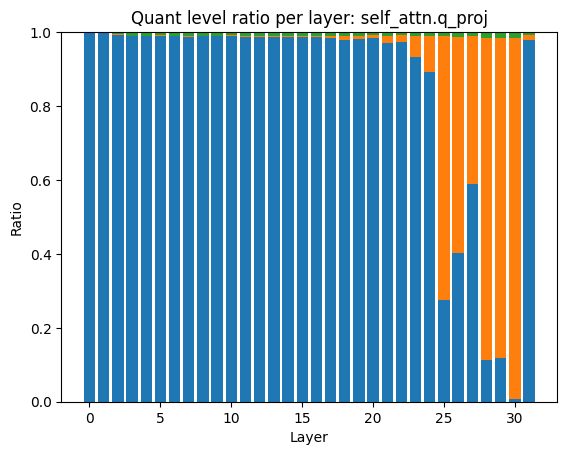

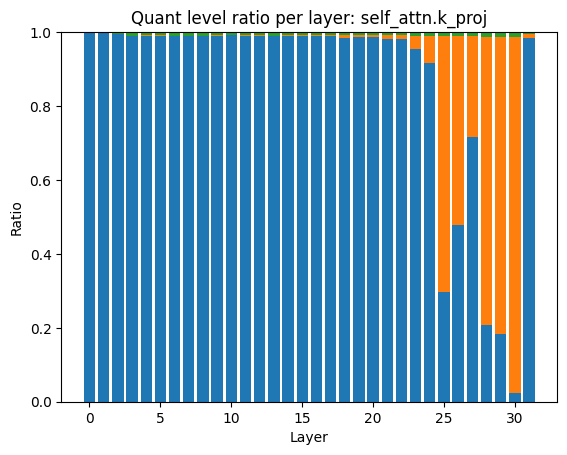

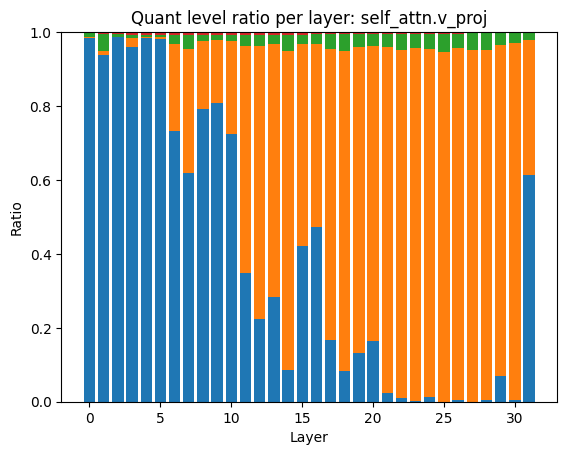

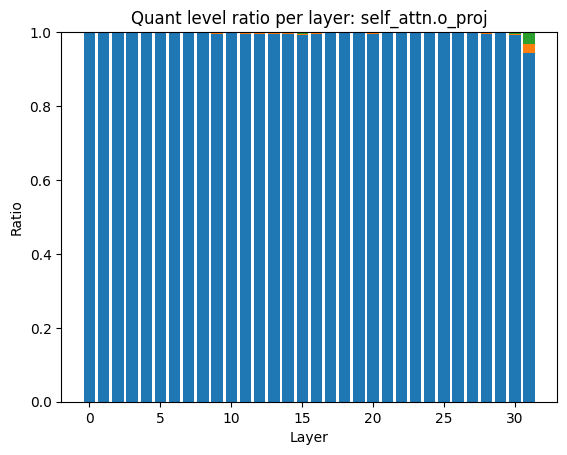

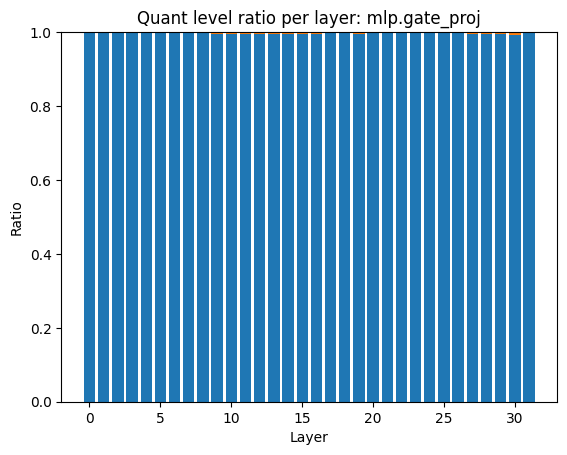

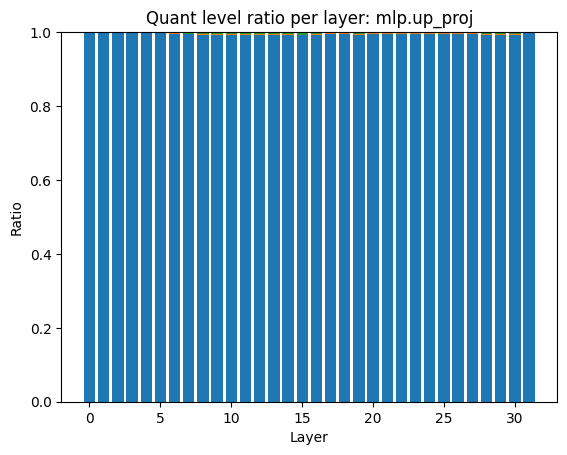

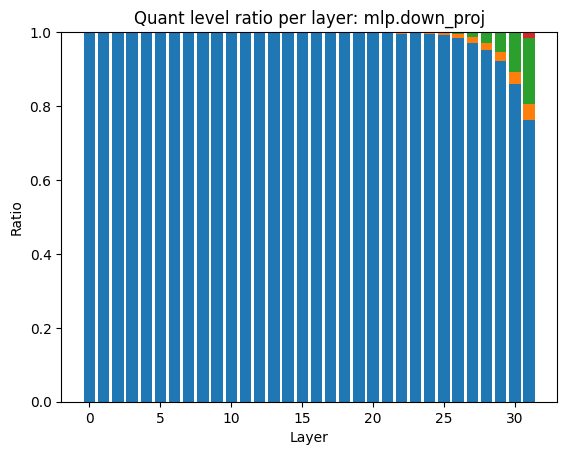

In [40]:
import matplotlib.pyplot as plt
import torch

# 예: ql = 0~3 전체 비율을 시각화
for n in named_linears.keys():

    all_layers = []
    for i in range(len(layers)):
        bincount = torch.bincount(qlevel_dict[f'{i}_{n}'], minlength=4).float()
        ratio = bincount / bincount.sum()
        all_layers.append(ratio)

    all_layers = torch.stack(all_layers)  # shape: (num_layers, 4)

    x = range(len(layers))
    labels = [f"ql={i}" for i in range(4)]
    bottom = torch.zeros(len(layers))

    for q in range(4):
        plt.bar(x, all_layers[:, q], bottom=bottom, label=labels[q])
        bottom += all_layers[:, q]

    plt.title(f'Quant level ratio per layer: {n}')
    plt.xlabel('Layer')
    plt.ylabel('Ratio')
    plt.ylim(0, 1)
    # plt.legend(bbox_to_anchor=(1, 0.9))
    plt.show()